In [144]:
# 导入必要模块
import torch
import numpy as np
from torchvision.datasets import mnist # 导入pytorch内置的minist数据集
import torchvision.transforms as transforms # 导入预处理模块
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [143]:
# 定义超参数
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 128
LR = 0.01
EPOCHES = 20
momentum = 0.5

In [135]:
# 下载数据并对数据进行预处理
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]) # 定义预处理函数,ToTensor将原始PIL图像[0,255]
                                                                                            # 变为[0,1]，然后标准化到[-1,1]
torch.manual_seed(100)
train_dataset = mnist.MNIST("./data", train=True, download=True, transform=transform)
test_dataset = mnist.MNIST("./data", train=False, download=True, transform=transform)
# dataloader是可迭代对象
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

torch.Size([128, 1, 28, 28])


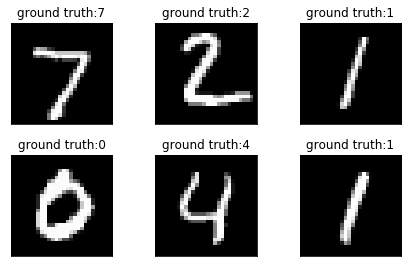

In [136]:
# 可视化原数据
import matplotlib.pyplot as plt
%matplotlib inline

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
fig = plt.figure()
print(example_data.shape)
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap="gray")
    plt.title("ground truth:{}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

In [137]:
# 构建网络
class Net(nn.Module):
    def __init__(self, in_dim, hidden1_dim, hidden2_dim, out_dim):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, hidden1_dim), nn.BatchNorm1d(hidden1_dim))
        self.layer2 = nn.Sequential(nn.Linear(hidden1_dim, hidden2_dim), nn.BatchNorm1d(hidden2_dim))
        self.layer3 = nn.Sequential(nn.Linear(hidden2_dim, out_dim))
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x
        
        

In [138]:
# 实例化网络
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = Net(28 * 28, 300, 100, 10)
# model = model.to(device)
model = model.cuda()

# 定义损失函数和优化器
criterion= nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=momentum)

cuda:0


In [139]:
# 训练模型
# 保存每个epoch的训练误差和测试误差
losses = []
acces = []
eval_losses = []
eval_acces = []

for epoch in range(EPOCHES):
    print("Epoch {} is starting!".format(epoch + 1))
    train_loss = 0
    train_acc = 0
    model.train()
    # 动态修改参数学习率
    if epoch % 5 == 0:
        optimizer.param_groups[0]["lr"] *= 0.1
    for img, label in train_loader:
#         img = img.to(device) # img的size:64x1x28x28
#         label = label.to(device)
        img = img.cuda()
        label = label.cuda()
        img = img.view(img.size(0), -1) # 64x28*28
        
        # 前向传播
        out = model(img)
        loss = criterion(out, label) # 一个batch的loss
        # 反向传播, 反向传播前，需要将梯度清零，否则默认情况下梯度是累加的
        optimizer.zero_grad()
        loss.backward() # 计算梯度
        optimizer.step() # 执行优化
        # 记录每次迭代的误差
        train_loss += loss.item() # loss.item()为每个batch的损失
        # 计算分类准确率
        _, pred = out.max(1)
        correct_nums = (pred == label).sum().item() # 每次迭代,分类正确的样本数
        acc = correct_nums / img.shape[0] # 每个batch的平均准确性
        train_acc += acc
    losses.append(train_loss / len(train_loader)) # len(train_loader)返回的是每个epoch含有多少次迭代，即多少个batch
    acces.append(train_acc / len(train_loader))
    
    # 训练完一个epoch后，在测试集上检测效果
    eval_loss = 0
    eval_acc = 0
    model.eval() # 模型改为预测模式,会把所有training属性设置为False
    for img, label in test_loader:
#         img = img.to(device)
#         label = label.to(device)
        img = img.cuda()
        label = label.cuda()
        img = img.view(img.shape[0], -1)
        out = model(img)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()
        _, pred = out.max(1)
        correct_nums = (pred == label).sum().item()
        eval_acc += (correct_nums / img.shape[0])

    eval_losses.append(eval_loss / len(test_loader))
    eval_acces.append(eval_acc / len(test_loader))
    
    print("epoch:{}, Train_loss:{:.4f}, Trian_acc:{:.4f} ".format(epoch + 1, train_loss / len(train_loader), train_acc / len(train_loader)))
    print("epoch:{}, eval_loss:{:.4f}, eval_acc:{:.4f} ".format(epoch + 1, eval_loss / len(test_loader), eval_acc / len(test_loader)))
        

Epoch 1 is starting!
epoch:1, Train_loss:1.0144, Trian_acc:0.7889 
epoch:1, eval_loss:0.5483, eval_acc:0.8991 
Epoch 2 is starting!
epoch:2, Train_loss:0.4789, Trian_acc:0.9006 
epoch:2, eval_loss:0.3564, eval_acc:0.9254 
Epoch 3 is starting!
epoch:3, Train_loss:0.3479, Trian_acc:0.9205 
epoch:3, eval_loss:0.2696, eval_acc:0.9374 
Epoch 4 is starting!
epoch:4, Train_loss:0.2817, Trian_acc:0.9325 
epoch:4, eval_loss:0.2310, eval_acc:0.9447 
Epoch 5 is starting!
epoch:5, Train_loss:0.2406, Trian_acc:0.9413 
epoch:5, eval_loss:0.1985, eval_acc:0.9504 
Epoch 6 is starting!
epoch:6, Train_loss:0.2212, Trian_acc:0.9452 
epoch:6, eval_loss:0.1947, eval_acc:0.9506 
Epoch 7 is starting!
epoch:7, Train_loss:0.2174, Trian_acc:0.9469 
epoch:7, eval_loss:0.1943, eval_acc:0.9511 
Epoch 8 is starting!
epoch:8, Train_loss:0.2163, Trian_acc:0.9464 
epoch:8, eval_loss:0.1908, eval_acc:0.9514 
Epoch 9 is starting!
epoch:9, Train_loss:0.2125, Trian_acc:0.9480 
epoch:9, eval_loss:0.1877, eval_acc:0.9527 
E

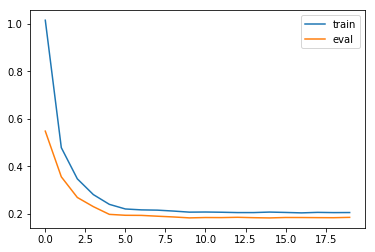

In [141]:
f1, = plt.plot(losses)
f2, = plt.plot(eval_losses)
plt.legend([f1, f2], ["train", "eval"])

# 动态修改优化器参数
修改优化器参数可以通过修改optimizer.params_groups或新建optimizer。
- optimizer.params_groups是长度为1的list,元素是一个字典，字典的键为优化器的各个参数。